# Assignment 2: Text Classification with Various Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models. You should also be able to develop an intuition for:


*   The effects of fine-tuning word vectors or starting with random word vectors
*   How various networks behave when the training set size changes
* The effect of shuffling your training data
*   The benefits of Attention calculations
* Working with BERT


The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

The initial part of the notebook is purely setup. We will then evaluate how Attention can make Deep Averaging networks better. 

Do not try to run this entire notebook on your GCP instance as the training of models requires a GPU to work in a timely fashion. This notebook should be run on a Google Colab leveraging a GPU. By default, when you open the notebook in Colab it will try to use a GPU. Total runtime of the entire notebook (with solutions and a Colab GPU) should be about 1h.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-summer-main/blob/master/assignment/a2/Text_classification.ipynb)

The overall assignment structure is as follows:

1. Setup
  
  1.1 Libraries, Embeddings,  & Helper Functions

  1.2 Data Acquisition

  1.3. Data Preparation

      1.3.1 Training/Test Sets using Word2Vec 

      1.3.2 Training/Test Sets for BERT-based models

2. Classification with various Word2Vec-based Models

  2.1 The Role of Shuffling of the Training Set

  2.2 DAN vs Weighted Averaging Models using Attention

    2.2.1 Warm-Up
    
    2.2.2 The WAN Model
    
  2.3 Approaches for Training of Embeddings 

3. Classification with BERT

  3.1. BERT Basics

  3.2 CLS-Token-based Classification 

  3.3 Averaging of BERT Outputs

  3.4. Adding a CNN on top of BERT



**INSTRUCTIONS:**: 

* Questions are always indicated as **QUESTION**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1.
* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 1 in bulk. This is setup work and no questions are in there. At the end of section 1 we will state all of the relevant variables that were defined and created in section 1.





## 1. Setup

### 1.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites that you must download. 

In [4]:
#@title Imports

!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet
!pip install pydot --quiet

     |████████████████████████████████| 24.2 MB 1.7 MB/s 
     |████████████████████████████████| 4.9 MB 35.8 MB/s 
     |████████████████████████████████| 4.2 MB 17.4 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.2 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 


Now we are ready to do the imports.

In [5]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

import numpy as np

Below is a helper function to plot histories.

In [6]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)

    # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
    if 'classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['classification_accuracy'])
    else:
      ax4.plot(history2.history['accuracy'])
    
    if 'val_classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['val_classification_accuracy'])
    else:
      ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

Next, we get the word2vec model from nltk.

In [7]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)


[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


Now here we have the embedding **model** defined, let's see how many words are in the vocabulary:

In [ ]:
len(model.vocab)

How do the word vectors look like? As expected:

In [ ]:
model['great'][:20]

We can now build the embedding matrix and a vocabulary dictionary:

In [8]:
#@title Embedding Matrix Creation

EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

In [ ]:
embedding_matrix

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for unknown words.

### 1.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [9]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples_batch, train_labels_batch = next(iter(train_data.batch(30000)))
test_examples_batch, test_labels_batch = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePSBJNO/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePSBJNO/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePSBJNO/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


It is always highly recommended to look at the data. 

In [ ]:
train_examples_batch[2:4]

In [ ]:
train_labels_batch[2:4]

For convenience, in this assignment we will define a maximum length and only keep the examples that are longer than that length

In [10]:
MAX_SEQUENCE_LENGTH = 100

For simplicity, we will also limit ourselves to examples that actually have at least MAX_SEQUENCE_LENGTH tokens.


## 1.3. Data Preparation

### 1.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [11]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples_batch)
test_tokens = tokenizer.tokenize(test_examples_batch)

Does this look right?

In [ ]:
train_tokens[0]

Yup... looks right. Of course we will need to take care of the encoding later.

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values.   

In [12]:
#@title Definition of sents_to_ids function

def sents_to_ids(token_list_list, label_list, num_examples=100000000):
    """
    converting a list of strings to a list of lists of word ids
    """
    text_ids = []
    text_labels = []
    valid_example_list = []
    example_count = 0
    use_token_list_list = token_list_list[:num_examples]
    for i, token_list in enumerate(use_token_list_list):
        if i < num_examples:
            try:
                example = []
                for token in list(token_list.numpy()):
                    decoded = token.decode('utf-8').replace('.','').replace(',','').replace('!','')
                    try:
                        example.append(vocab_dict[decoded])
                  
                    except:
                        example.append(43981)
                if len(example) >= MAX_SEQUENCE_LENGTH:
                    text_ids.append(example[:MAX_SEQUENCE_LENGTH])
                    text_labels.append(label_list[i])
                    if example_count % 5000 == 0:
                        print('Examples processed: ', example_count)
                    valid_example_list.append(i) 
                    example_count += 1
                else:
                    pass
            except:
                pass

    
    print('Number of examples retained: ', example_count) 
    return (np.array(text_ids),   np.array(text_labels), valid_example_list) 

Now we can create training and test data that can be fed into the models of interest.

In [13]:
train_input_ids, train_input_labels, train_valid_example_list = sents_to_ids(train_tokens, train_labels_batch)
test_input_ids, test_input_labels, test_valid_example_list = sents_to_ids(test_tokens, test_labels_batch)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Number of examples retained:  17418
Examples processed:  0
Number of examples retained:  4329


The variable 'train_valid_example_list' contains the list of chosen examples that we can use later for the construction of the BERT training and test sets.

In [ ]:
train_valid_example_list[:5]

Examples 3 and 4 were apparently shorten than our target length. 

We will also create a reduced training dataset with only 1000 examples to study the effect of the dataset size.


In [14]:
REDUCED_TRAINING_SIZE = 1000

train_input_ids_reduced = train_input_ids[:REDUCED_TRAINING_SIZE]
train_input_labels_reduced = train_input_labels[:REDUCED_TRAINING_SIZE]

Let's convince ourselves that the data looks correct:

In [22]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 34710,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 38195, 23807, 42958,
        35058, 34177, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 26144,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 29168, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 38341, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511,  9337, 21807, 39168, 43981, 16856, 28070, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 34194, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 33741,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456,  4942, 34554, 33013,  1200, 27498, 43981, 1880

### 1.3.2. Training/Test Sets for BERT-based models

We already imported the BERT model and the Tokenizer libraries. Now, we create the tokenizer:

In [15]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Since the Tokenizer of BERT is not a whitespace tokenizer, each sentence will almost certainly result in more BERT tokens than whitespace tokens. Since we don't want to cheat by showing BERT more examples than other models we should restrict ourselves to the data that will also be seen by the other models:  

In [16]:
#@title Limit BERT data to the set used with word2vec 
all_train_examples = [x.decode('utf-8') for x in train_examples_batch.numpy()]
all_test_examples = [x.decode('utf-8') for x in test_examples_batch.numpy()]

bert_valid_train_examples_text = []
bert_valid_train_examples_labels = []

bert_valid_test_examples_text = []
bert_valid_test_examples_labels = []

for valid_example in train_valid_example_list:
  bert_valid_train_examples_text.append(all_train_examples[valid_example])
  bert_valid_train_examples_labels.append(train_labels_batch[valid_example])

for valid_example in test_valid_example_list:
  bert_valid_test_examples_text.append(all_test_examples[valid_example])
  bert_valid_test_examples_labels.append(test_labels_batch[valid_example])




Next, we will create our training and test sets for BERT models.

In [17]:
#@title BERT Tokenization of training and test data

num_train_examples = 2500000
num_test_examples = 500000

max_length = MAX_SEQUENCE_LENGTH


x_train = bert_tokenizer(bert_valid_train_examples_text[:num_train_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = bert_valid_train_examples_labels[:num_train_examples]

x_test = bert_tokenizer(bert_valid_test_examples_text[:num_test_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = bert_valid_test_examples_labels[:num_test_examples]


def select_min_length_examples(x_data, y_data):

  x_input_ids = []
  y_labels = []

  for ((input_ids, masks), label) in zip(zip(x_data['input_ids'], x_data['attention_mask']), y_data):
    if masks[-1] == 1:
      x_input_ids.append(input_ids)
      y_labels.append(label)

  return np.array(x_input_ids), np.array(y_labels) 


Next, we will simplify our lives for the purpose of the bulk of the assignment. We know that 1) all inputs  have at least MAX_SEQUENCE_LENGTH tokens, and 2) the input has one section not 2. Therefore, BERT will produce consistent results if we only use the 'input_ids'.

Let us create the corresponding data sets:

In [18]:
bert_train_input_ids, bert_train_labels = select_min_length_examples(x_train, y_train)
bert_test_input_ids, bert_test_labels = select_min_length_examples(x_test, y_test)

How many training examples do we have?

In [23]:
bert_train_input_ids.shape

(17418, 100)

Great. Looks like the same size training set that we used for the word2vec-based models.

We also want to create again a reduced set of size REDUCED_TRAINING_SIZE: 

In [19]:
bert_train_input_ids_reduced = bert_train_input_ids[:REDUCED_TRAINING_SIZE]
bert_train_labels_reduced = bert_train_labels[:REDUCED_TRAINING_SIZE]

Overall, here are the key variables and sets that we created, and that may be used moving forward. If the variable naming does not make it obvious, we also state the purpose:

Parameters:

* MAX_SEQUENCE_LENGTH (100)
* REDUCED_TRAINING_SIZE (1000)

Word2vec-based models:

*   train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels
*   train(/test)_input_ids_reduced: input ids for the reduced training(/test) sets for word2vec models
* train(/test)_input_labels_reduced: the corresponding labels for the reduced set

BERT:


*   bert_train(/test)_input_ids: input ids for the training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for BERT
*   bert_train(/test)_input_ids_reduced : input ids for the reduced training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for the reduced set for BERT

**NOTE:** We recommend to inspect these variables if you have not gone through the code.

## 2. Classification with various Word2Vec-based Models

**QUESTION:**

2.a. Revisit the dataset. Is it balanced? Find the ratio of positive examples for the training sets.

2.b. Find the ratio of positive examples for both the test set.

In [24]:
### YOUR CODE HERE

def find_ratio(labels):
  length = labels.size
  positive_count = 0
  negative_count = 0

  for i in range (length):
    if labels[i] == 1:
      positive_count += 1
    elif labels[i] == 0:
      negative_count += 1

  positive = round((positive_count/length),5)
  negative = round((negative_count/length),5)

  return positive, negative

pos_train_full, neg_train_full = find_ratio(train_input_labels)
pos_train_red, neg_train_red = find_ratio(train_input_labels_reduced)

print(f'Positive:Negative Ratio (Train Full) - ', pos_train_full, ':', neg_train_full)
print(f'Positive:Negative Ratio (Train Reduced) - ', pos_train_red, ':', neg_train_red)


### END YOUR CODE

Positive:Negative Ratio (Train Full) -  0.49351 : 0.50649
Positive:Negative Ratio (Train Reduced) -  0.5 : 0.5


In [25]:
### YOUR CODE HERE
pos_test_full, neg_test_full = find_ratio(test_input_labels)
print(f'Positive:Negative Ratio (Test Full) - ', pos_test_full, ':', neg_test_full)

### END YOUR CODE

Positive:Negative Ratio (Test Full) -  0.49688 : 0.50312


### 2.1 The Role of Shuffling of the Training Set


We will first revisit the DAN model. 

2. Reuse the code from the class notebook to build a DAN network with one hidden layer of dimension 100. The optimizer should be Adam. Wrap the model creation in a function according to this API:

In [26]:
def create_dan_model(retrain_embeddings=False, 
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec', 
                     learning_rate=0.001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'

  
  ### YOUR CODE HERE

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.

  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=embeddings_initializer,
                            input_length=max_sequence_length,
                            trainable=retrain_embeddings)

  dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')
  dan_embeddings = dan_embedding_layer(dan_input_layer)
  dan_avg_input_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(dan_embeddings)
  
  dan_hidden_out_1 = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_1')(dan_avg_input_embeddings)
  dan_hidden_out_1 = tf.keras.layers.Dropout(dropout)(dan_hidden_out_1)

  dan_classification = tf.keras.layers.Dense(1, 
                                           activation='sigmoid', 
                                           name='dan_classification')(dan_hidden_out_1)

  dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
  dan_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics='accuracy')                                    
  ### END YOUR CODE
  return dan_model


Let us create a sorted dataset to run our simulations:

In [27]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

Next, try to create your DAN model using the default parameters and train it by:

1.  Using the sorted dataset
2.  Using 'shuffle=False' as one of the model.fit parameters.

Make sure you store the history (name it 'dan_sorted_history') as we did in the lesson notebooks. 



In [28]:
### YOUR CODE HERE

dan_model_sorted = create_dan_model()
dan_model_sorted.summary()

#use dan_sorted_history = ... below
dan_sorted_history = dan_model_sorted.fit(sorted_training_input_ids,
                        sorted_training_labels,
                        validation_data=(test_input_ids, test_input_labels),
                        batch_size=32,
                        epochs=20,
                        shuffle=False
             )

### END YOUR CODE                        

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 dan_classification (Dense)  (None, 1)                 101       
                                                                 
Total params: 13,224,801
Trainable params: 30,201
Non-train

**QUESTION:**

2.1.a Which number (in percent) is closest to the highest validation accuracy that you observed?

  - 50

Next, recreate the same model and train with **'shuffle=True'**. (Note that this is also the default.). Use 'dan_suffled_history' for the history.

In [29]:
### YOUR CODE HERE

dan_model_shuffled = create_dan_model()                                                      

#use dan_suffled_history = ... below
dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                        sorted_training_labels,
                        validation_data=(test_input_ids, test_input_labels),
                        batch_size=32,
                        epochs=20,
                        shuffle=True)

### END YOUR CODE                        

Epoch 1/20
545/545 [==============================] - 4s 7ms/step - loss: 0.6412 - accuracy: 0.6495 - val_loss: 0.5965 - val_accuracy: 0.6909
Epoch 2/20
545/545 [==============================] - 2s 4ms/step - loss: 0.5465 - accuracy: 0.7323 - val_loss: 0.5397 - val_accuracy: 0.7283
Epoch 3/20
545/545 [==============================] - 2s 3ms/step - loss: 0.5089 - accuracy: 0.7523 - val_loss: 0.5173 - val_accuracy: 0.7413
Epoch 4/20
545/545 [==============================] - 2s 3ms/step - loss: 0.4971 - accuracy: 0.7570 - val_loss: 0.5097 - val_accuracy: 0.7475
Epoch 5/20
545/545 [==============================] - 2s 4ms/step - loss: 0.4877 - accuracy: 0.7628 - val_loss: 0.5041 - val_accuracy: 0.7487
Epoch 6/20
545/545 [==============================] - 2s 4ms/step - loss: 0.4806 - accuracy: 0.7688 - val_loss: 0.4992 - val_accuracy: 0.7558
Epoch 7/20
545/545 [==============================] - 2s 4ms/step - loss: 0.4766 - accuracy: 0.7713 - val_loss: 0.5002 - val_accuracy: 0.7531
Epoch 

**QUESTION:**

2.1.b Which number (in percent) is closest to the highest validation accuracy that you observed for the shuffled run?

  - 75


Compare the 2 histories in a plot.

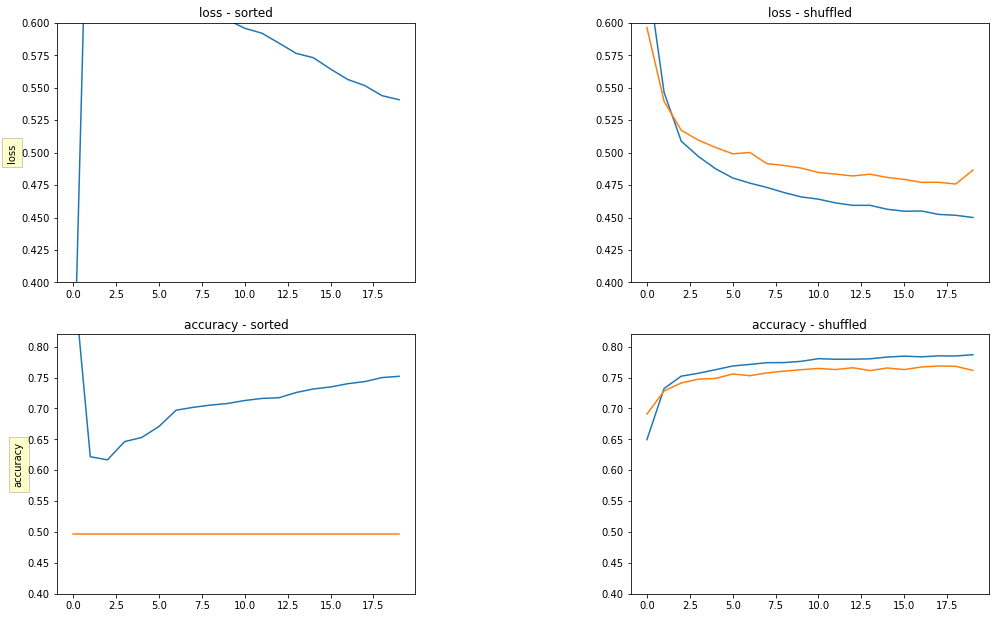

In [30]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_sorted_history,
          dan_shuffled_history, 
          model_1_name='sorted',
         model_2_name='shuffled',
         y_lim_accuracy_lower=0.40,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 2.2 DAN vs Weighted Averaging Models using Attention 

#### 2.2.1. Warm-Up: Manual Attention Calculation

QUESTION: 

2.2.1.a Calculate the context vector for the following query and key/value vectors. You can do this manually, or you can use 


```
tf.keras.layers.Attention()
```

2.2.1.b What are the weights for the key/value vectors?


In [31]:
q = [1, 2., 1]

k1 = v1 = [-1, -1, 3.]
k2 = v2 = [1, 2, -5.]

In [32]:
### YOUR CODE HERE
test_query = np.array([q])
test_values = np.array([k1, k2])
tf.keras.layers.Attention()([test_query, test_values], return_attention_scores=True)
### END YOUR CODE

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0. ,  0.5, -1. ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>)

#### 2.2.2 The 'WAN' Model


Next, we would like to improve our DAN by attempting to train a neural net that learns to put more weight on some words than others. How could we do that? **Attention** is the answer!

Here, we will build a model that you can call "Weighted Averaging Models using Attention". You should construct a network that uses attention to weigh the input tokens for a given example.

The core structure is the same as for the DAN network, but there are obviously some critical changes:

1) How do I create a learnable query vector for the attention calculation, that is supposed to generate the suitable token probabilities? And what is its size?

2) What are the key vectors for the attention calculation?

3) How does the averaging change? 


First, the key vectors should be the incoming word vectors.

The query vector needs to have the size of the word vectors, as it needs to attend to them. A good way to create the query vector is to generate an embedding for it that you then make trainable:


```
wan_query_embedding_layer = Embedding(1,  
                                      embedding_matrix.shape[1], 
                                      input_length=1,  
                                      trainable=True)
```

would create an embedding of the proper size for 1 vector.

That sounds great... but how do I use this embedding to have a vector available in my calculation? And... make this vector available to all examples in the batch?

What you can use is a 'fake input-like layer' that creates for each incoming batch example a '0', that then the query embedding layer can get applied to.
Assuming that the input layer for your network is **wan_input_layer**, this could be done with

```
wan_zero_input = tf.cast((wan_input_layer[:, :1] < -1), 'int64') 
```

You could then have the query vector available for each example through:

```
wan_query_vector = wan_query_embedding_layer(wan_zero_input)
```

You will see that this structure is essentially  the same as what we did for word vectors, except that we had to replace the input layer with our fake layer, as there is no actual input. We will also have **2 outputs** (discussed in a bit.)

How does the averaging change? You should use:

```
tf.keras.layers.Attention()
```

and make sure you consider the proper inputs and outputs for that calculation.

So why 2 outputs, and how do we do that? First off, we need the output that makes the classification, as always. What is the second output? We also would like our model to provide us with the attention weights it calculated. This will tell us which words were considered how much for the context creation.

We can we implement 2 outputs? You need to have a list of the two outputs. But note that you may also want to have a a list of 2 cost function and 2 metrics. You can use 'None' both times to account for our new second output, and you can ignore the corresponding values that the model report. (In general, the total loss will be a sum of the individual losses. So one would rather construct a loss that always returns zero for the second loss, but as it is very small we can ignore this here.)


In [ ]:
fake_test_input = tf.constant([[17, 32, 56, 34], [564,23,245, 54]])

wan_zero_input = tf.cast((fake_test_input[:, :1] < -1), 'int64')

print(wan_zero_input)


In [34]:
wan_query_embedding_layer = Embedding(1,
                                      100,
	                                    input_length=1,
	                                    trainable=True,
	                                    name='query_embedding')

print(wan_query_embedding_layer(wan_zero_input))

tf.Tensor(
[[[-0.01273077 -0.01407808 -0.0041371  -0.04247764  0.04539776
    0.00486866 -0.03308704  0.02256596 -0.02542434 -0.03551005
   -0.0213559  -0.01312661 -0.03851898 -0.02844409 -0.03247529
   -0.00107785 -0.02909371  0.04838965  0.00139568 -0.00814654
   -0.02910929  0.00665343 -0.0324382  -0.01958717  0.00152136
    0.00762372 -0.0023661   0.0215992  -0.0043138  -0.0291266
    0.0020499  -0.04806005  0.0492892   0.04061656 -0.01748215
   -0.03159838 -0.00659087 -0.04223827 -0.02179668 -0.00159388
    0.01193293  0.02416622 -0.0085898   0.00495362  0.00594749
   -0.04811163 -0.00377094 -0.00558522 -0.00746727 -0.0295145
    0.00107396 -0.04303714 -0.01158424 -0.00607116  0.02213787
    0.03904775 -0.01714998  0.01671078  0.04808059 -0.0078507
   -0.01244999 -0.01622807  0.04757446  0.01410222 -0.0121492
    0.02014666 -0.01758043 -0.02045313 -0.0135925  -0.04723616
   -0.04056096  0.04952681 -0.0335141   0.04427815  0.00231987
   -0.01355899  0.04127845 -0.01326985  0.034523

In [35]:
def create_wan_model(retrain_embeddings=False, 
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     learning_rate=0.001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """
  ### YOUR CODE HERE

  #store initializer
  embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)

  #create query embedding layer
  wan_query_embedding_layer = Embedding(1,  
                                      embedding_matrix.shape[1], 
                                      input_length=1,  
                                      trainable=True)
  
  #create wan embedding layer with parameters
  wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings,
                                  name='wan_embedding_layer')
  
  #layer construction
  wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64', name='wan_input_layer')

  #attention layer for averaging layer
  wan_zero_input = tf.cast((wan_input_layer[:, :1] < -1), 'int64', name='wan_zero_input') 
  
  #create query vector using zero_input
  wan_query_vector = wan_query_embedding_layer(wan_zero_input)
  
  #create embeddings
  wan_embeddings = wan_embedding_layer(wan_input_layer)

  #store attention context/weights, reshape context
  attention_context, attention_weights = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings], return_attention_scores=True)
  attention_context_reshaped = tf.keras.layers.Reshape((embedding_matrix.shape[1],))(attention_context)

  #create hidden layers
  wan_hidden_out_1 = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_1')(attention_context_reshaped)
  wan_hidden_out_1 = tf.keras.layers.Dropout(dropout)(wan_hidden_out_1)
  
  #classification
  wan_classification = tf.keras.layers.Dense(1, 
                                            activation='sigmoid', 
                                            name='classification')(wan_hidden_out_1)

  #model definition
  wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification, attention_weights])
  
  #compile with loss func and correct metrics
  wan_model.compile(loss=['binary_crossentropy', None],
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                  beta_1=0.9,
                                                  beta_2=0.999,
                                                  epsilon=1e-07,
                                                  amsgrad=False,
                                                  name='Adam'),
                                                  metrics=['accuracy', None])
  
  #display summary
  wan_model.summary()
  display(keras.utils.plot_model(wan_model, show_shapes=True, dpi=90))

  ### END YOUR CODE
  return wan_model





Now run the model for the same dataset as we did for the DAN model and save it in its history 'wan_history':

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wan_input_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 1)           0           ['wan_input_layer[0][0]']        
 icingOpLambda)                                                                                   
                                                                                                  
 tf.math.less (TFOpLambda)      (None, 1)            0           ['tf.__operators__.getitem_1[0][0
                                                                 ]']                              
                                                                                            

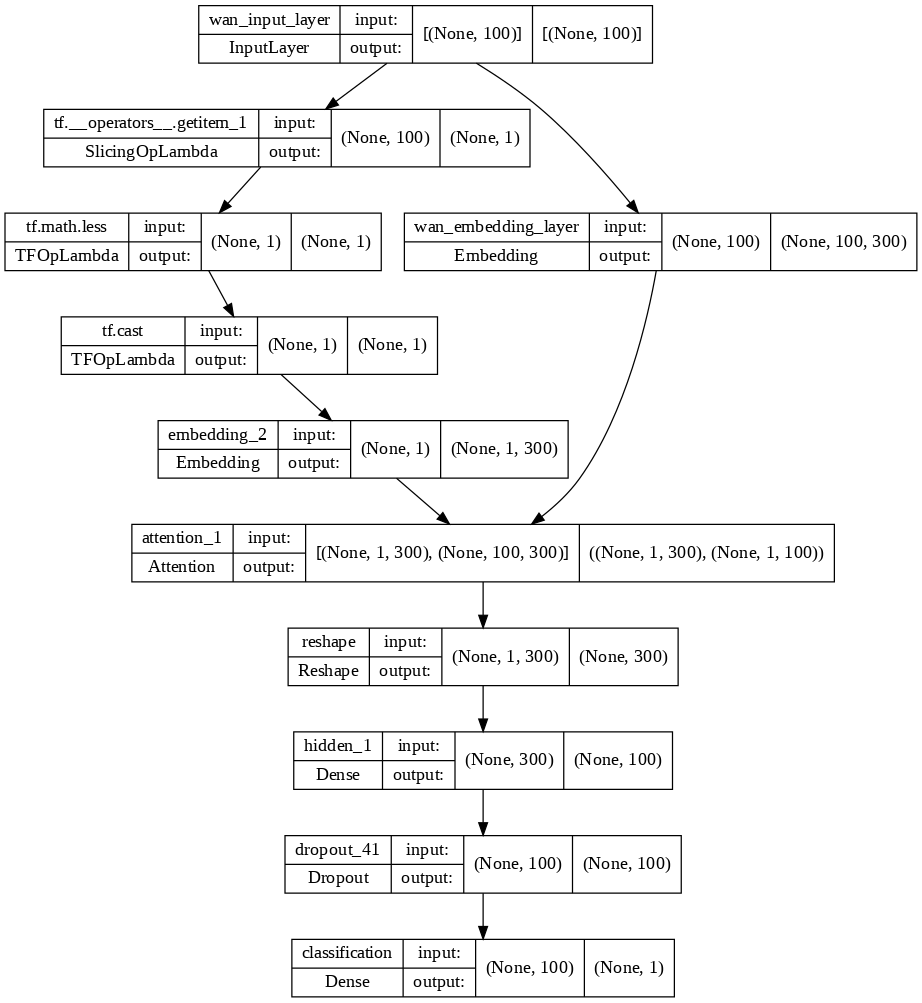

Epoch 1/20
545/545 [==============================] - 4s 5ms/step - loss: 0.5877 - classification_loss: 0.5877 - classification_accuracy: 0.6941 - attention_1_accuracy: 0.0083 - val_loss: 0.4959 - val_classification_loss: 0.4959 - val_classification_accuracy: 0.7621 - val_attention_1_accuracy: 0.0056
Epoch 2/20
545/545 [==============================] - 3s 5ms/step - loss: 0.4721 - classification_loss: 0.4721 - classification_accuracy: 0.7756 - attention_1_accuracy: 0.0064 - val_loss: 0.4738 - val_classification_loss: 0.4738 - val_classification_accuracy: 0.7702 - val_attention_1_accuracy: 0.0046
Epoch 3/20
545/545 [==============================] - 3s 5ms/step - loss: 0.4570 - classification_loss: 0.4570 - classification_accuracy: 0.7818 - attention_1_accuracy: 0.0063 - val_loss: 0.4661 - val_classification_loss: 0.4661 - val_classification_accuracy: 0.7729 - val_attention_1_accuracy: 0.0041
Epoch 4/20
545/545 [==============================] - 3s 5ms/step - loss: 0.4464 - classificat

In [36]:
### YOUR CODE HERE

wan_model = create_wan_model()

# use wan_history = ... below
wan_history = wan_model.fit(sorted_training_input_ids,
                        sorted_training_labels,
                        validation_data=(test_input_ids, test_input_labels),
                        batch_size=32,
                        epochs=20,
                        shuffle=True)

### END YOUR CODE

**QUESTION:**

2.2.2.a Which number (in percent) is closest to the highest validation accuracy that you observed for the wan training?

 * 78

Now compare the results of the initial dan_model training and the wan_model training:

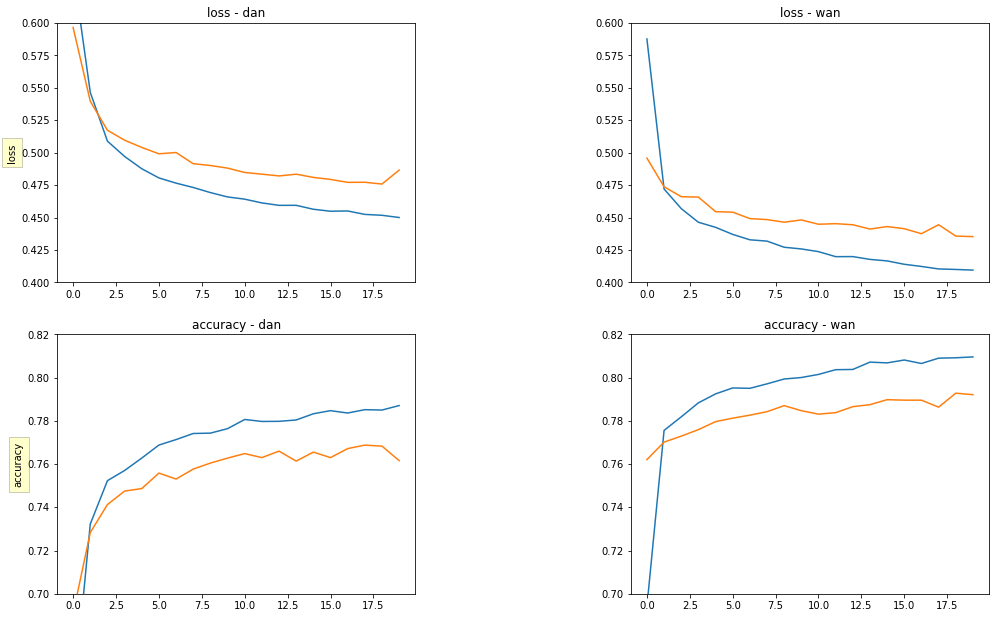

In [37]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_shuffled_history,
          wan_history, 
          model_1_name='dan',
         model_2_name='wan',
         y_lim_accuracy_lower=0.70,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Next, let us see for the wan_model which words did matter for the classification and which ones did less so. How can we tell? We can look at the attention weights!

Consider the first training example:

In [38]:
train_examples_batch[0].numpy().decode('utf-8')

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

The corresponding input ids that are suitable formatted, i.e. with max length 100, are these:

In [ ]:
probe_input_ids = train_input_ids[0]
probe_input_ids

and the first 10 corresponding tokens are: 

In [39]:
probe_tokens = [x.decode('utf-8') for x in train_tokens[0].numpy()][:100]
probe_tokens[:10]

['This',
 'was',
 'an',
 'absolutely',
 'terrible',
 'movie.',
 "Don't",
 'be',
 'lured',
 'in']

Identify the 5 words with the highest impact and the 5 words with the lowest impact on the score, i.e., identify the 5 words with the largest and  smallest weights, respectively. (Not that multiple occurances of the same word count separately for the exercise).

HINT: You should create a list of (word/weight) pairs, and then sort by the second argument. Python's '.sort()' function may come in handy.

In [40]:
### YOUR CODE HERE

# 'pairs' should be the variable that holds the  token/weight pairs.
first_sent_weights = wan_model.predict(train_input_ids[:1])[1][0][0]
sorted = np.argsort(first_sent_weights)

largest_weights = sorted[:10]
smallest_weights = sorted[-10:].tolist()[::-1]

wght_idx = np.concatenate((smallest_weights, largest_weights))

pairs = []

for idx in wght_idx:
  pairs.append((first_sent_weights[idx], probe_tokens[idx]))
  
### END YOUR CODE

print('most important tokens:')
print('\t', pairs[:10])
print('\nleast important tokens:')
print('\t', pairs[-10:])



most important tokens:
	 [(0.09375433, 'worst'), (0.07295638, 'terrible'), (0.042977538, 'pathetic'), (0.042977538, 'pathetic'), (0.035451468, 'disappointed'), (0.030038077, 'ridiculous'), (0.027670952, 'devoid'), (0.02298943, 'nothing'), (0.018553773, 'Even'), (0.017143017, 'emotional')]

least important tokens:
	 [(0.0013829549, 'the'), (0.0018908301, 'or'), (0.0019768868, 'their'), (0.0019768868, 'their'), (0.0019768868, 'their'), (0.002148331, 'be'), (0.002148331, 'be'), (0.002261895, 'I'), (0.002347771, 'this'), (0.002347771, 'this')]


 **QUESTION:**

 2.2.2.b List the 5 most important words, with the most important first. (Again, if a word appears twice, note it twice.)

 [worst, terrible, pathetic, pathetic, disappointed]

 2.2.2.c List the 5 least important words, with the most important of those first. (Again, if a word appears twice, note it twice.)

 [the, or, their, their, their]

### 2.3 Approaches for Training of Embeddings

Rerun the DAN Model in 3 configurations:


1.   embedding_initializer = 'word2vec' and retrain_embeddings=False
2.   embedding_initializer = 'word2vec' and retrain_embeddings=True
3.   embedding_initializer = 'uniform' and retrain_embeddings=True


**NOTE:** Train the models with static embeddings for 10 epochs and the ones with trainable embeddings for 3 epochs. 

What do you observe?



In [41]:
### YOUR CODE HERE
  
dan_model_1 = create_dan_model(embedding_initializer = 'word2vec', retrain_embeddings=False)
dan_model_2 = create_dan_model(embedding_initializer = 'word2vec', retrain_embeddings=True)
dan_model_3 = create_dan_model(embedding_initializer = 'uniform', retrain_embeddings=True)

### END YOUR CODE

**QUESTION:**

2.3.a Which number (in percent) is closest to the highest validation accuracy that you observed for the static model?

 * 76

In [42]:
#dan_model_1 = create_dan_model(embedding_initializer = 'word2vec', retrain_embeddings=False)

dan_shuffled_history_1 = dan_model_1.fit(sorted_training_input_ids,
                        sorted_training_labels,
                        validation_data=(test_input_ids, test_input_labels),
                        batch_size=32,
                        epochs=10,
                        shuffle=True)

Epoch 1/10
545/545 [==============================] - 3s 5ms/step - loss: 0.6460 - accuracy: 0.6480 - val_loss: 0.5982 - val_accuracy: 0.6962
Epoch 2/10
545/545 [==============================] - 2s 4ms/step - loss: 0.5468 - accuracy: 0.7362 - val_loss: 0.5384 - val_accuracy: 0.7297
Epoch 3/10
545/545 [==============================] - 2s 4ms/step - loss: 0.5123 - accuracy: 0.7518 - val_loss: 0.5191 - val_accuracy: 0.7394
Epoch 4/10
545/545 [==============================] - 2s 4ms/step - loss: 0.4963 - accuracy: 0.7600 - val_loss: 0.5203 - val_accuracy: 0.7450
Epoch 5/10
545/545 [==============================] - 2s 3ms/step - loss: 0.4901 - accuracy: 0.7621 - val_loss: 0.5053 - val_accuracy: 0.7528
Epoch 6/10
545/545 [==============================] - 2s 4ms/step - loss: 0.4817 - accuracy: 0.7681 - val_loss: 0.5031 - val_accuracy: 0.7554
Epoch 7/10
545/545 [==============================] - 2s 4ms/step - loss: 0.4789 - accuracy: 0.7702 - val_loss: 0.4988 - val_accuracy: 0.7591
Epoch 

**QUESTION:**


2.3.b Which number (in percent) is closest to the highest validation accuracy that you observed for the model where you initialized with word2vec vectors but allow them to retrain?

 * 81

In [43]:
#dan_model_2 = create_dan_model(embedding_initializer = 'word2vec', retrain_embeddings=True)

dan_shuffled_history_2 = dan_model_2.fit(sorted_training_input_ids,
                        sorted_training_labels,
                        validation_data=(test_input_ids, test_input_labels),
                        batch_size=32,
                        epochs=3,
                        shuffle=True)

Epoch 1/3
545/545 [==============================] - 7s 11ms/step - loss: 0.4992 - accuracy: 0.7579 - val_loss: 0.4221 - val_accuracy: 0.8062
Epoch 2/3
545/545 [==============================] - 7s 13ms/step - loss: 0.2965 - accuracy: 0.8778 - val_loss: 0.5006 - val_accuracy: 0.7762
Epoch 3/3
545/545 [==============================] - 9s 16ms/step - loss: 0.2036 - accuracy: 0.9247 - val_loss: 0.5309 - val_accuracy: 0.7824


**QUESTION:**

2.3.c Which number (in percent) is closest to the highest validation accuracy that you observed for the model where you initialized randomly and then trained?

 * 80



In [ ]:
#dan_model_3 = create_dan_model(embedding_initializer = 'uniform', retrain_embeddings=True)

dan_shuffled_history_3 = dan_model_3.fit(sorted_training_input_ids,
                        sorted_training_labels,
                        validation_data=(test_input_ids, test_input_labels),
                        batch_size=32,
                        epochs=3,
                        shuffle=True)

Epoch 1/3
545/545 [==============================] - 80s 146ms/step - loss: 0.4965 - accuracy: 0.7473 - val_loss: 0.4216 - val_accuracy: 0.8050
Epoch 2/3
545/545 [==============================] - 79s 145ms/step - loss: 0.2910 - accuracy: 0.8827 - val_loss: 0.4490 - val_accuracy: 0.7970
Epoch 3/3
545/545 [==============================] - 79s 145ms/step - loss: 0.1969 - accuracy: 0.9271 - val_loss: 0.5469 - val_accuracy: 0.7799



##3. BERT-based Classification Models

Now we turn to classification with BERT. We will perform classifications with various models that are based on pre-trained BERT models.


### 3.1. Basics

Let us first explore some basics of BERT. 

You first need to define the tokenizer and the model for the pre-trained configuration you need.

We already got the tokenizer during setup with:

```
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
```

Now, we also need to get the model:

In [48]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [49]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(Ignore the warnings.)

Next, consider this input:

In [47]:
test_input = ['this bank is closed on Sunday', 'the steepest bank of the river is dangerous']

Now apply the tokenizer to tokenize it:

In [50]:
tokenized_input = bert_tokenizer(test_input, 
                                 max_length=12,
                                 truncation=True,
                                 padding='max_length', 
                                 return_tensors='tf')

tokenized_input

{'input_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[ 101, 1142, 3085, 1110, 1804, 1113, 3625,  102,    0,    0,    0,
           0],
       [ 101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249,  102,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int32)>}

 QUESTION: 
 
 3.1.a  Why do the attention_masks have 4 and 1 zeros, respectively?

  *  For the first example 5 positions are padded while for the second one it is only one.

------


Next, let us look at the BERT outputs for these 2 sentences:

In [51]:
### YOUR CODE HERE

bert_output = bert_model(tokenized_input)

print(f'Shape of first BERT output: ', bert_output[0].shape, '\n')
print(f'Shape of second BERT output:: ', bert_output[1].shape, '\n')

print(f'First BERT output: ',  bert_output[0], '\n')
print(f'Second BERT output: ', bert_output[1], '\n')


### END YOUR CODE

Shape of first BERT output:  (2, 12, 768) 

Shape of second BERT output::  (2, 768) 

First BERT output:  tf.Tensor(
[[[ 0.3945215   0.04198515  0.06480412 ...  0.05045468  0.2235888
    0.24238206]
  [-0.09458941  0.06673873 -0.03607529 ...  0.21925794 -0.06967171
    0.7444843 ]
  [ 0.00561046  0.31316507 -0.17982745 ...  0.19563255 -0.10614748
    0.477736  ]
  ...
  [ 0.22268727 -0.115586    0.15854388 ...  0.3002531   0.01634064
    0.5133399 ]
  [ 0.31638375 -0.10986965  0.23661818 ...  0.10924109 -0.14340335
    0.32835382]
  [ 0.34834027 -0.10076497  0.26903206 ...  0.127076   -0.1843014
    0.26176214]]

 [[ 0.44506386  0.22265004 -0.09972464 ... -0.23736243  0.12722528
    0.07778173]
  [ 0.07407638 -0.3180583  -0.1192466  ... -0.0668015  -0.3061705
    0.46923533]
  [ 0.3145813   0.62658817  0.00606306 ... -0.03697472 -0.08461309
    0.7268304 ]
  ...
  [ 0.69994617 -0.11628406  0.01613361 ... -0.47437245  0.05725142
    0.21830113]
  [ 0.5602969   0.08535822 -0.91923475 ...

 QUESTION: 
 
 3.1.b How many outputs are there? 2

 3.1.c Which output do we need to use to get token-level embeddings?

 * the first

 3.1.d Which token number corresponds to 'bank' in the first sentence? ('bert_tokenizer.tokenize()' may come in handy.. and don't forget the CLS token! ) 2

 3.1.e Which token number corresponds to 'bank' in the second sentence? 4

 3.1.f What is the cosine similarity between the BERT outputs for the two occurances of 'bank' in the two sentences?

 3.1.g How does this relate to the cosine similarity of 'this' (sentence 1) and 'the' (sentence 2). Compute the cosine similarity.

 Enter your code below.

In [53]:
### YOUR CODE HERE

#1. -> print it out
print('Part B: ', bert_output)
print('Num outputs: ', len(bert_model(tokenized_input)), '\n')

#2. -> answer in answer file

#3. -> Look at tokenization
print('Part D: ')
tokenization = bert_tokenizer.tokenize(test_input[0])
bank_token = bert_tokenizer(['this bank is closed on Sunday', 'the steepest bank of the river is dangerous'])
print(tokenization)
print('Bank token is (first sent): 2\n')

#4. -> Look at tokenization
print('Part E: ')
tokenization = bert_tokenizer.tokenize(test_input[1])
bank_token = bert_tokenizer(['this bank is closed on Sunday', 'the steepest bank of the river is dangerous'])
print(tokenization)
print('Bank token is (second sent): 4\n')

#5.  -> get the vectors and calclate cosine similarity
def cosine_distances(vecs):
    for v_1 in vecs:
        distances = ''
        for v_2 in vecs:
            distances += ('\t' + str(np.dot(v_1, v_2)/np.sqrt(np.dot(v_1, v_1) * np.dot(v_2, v_2)))[:4])
        print(distances)

print('Part F: ')
bert_bank_outputs = bert_model(tokenized_input)
bank_1 = bert_bank_outputs[0][0, 2]
bank_2 = bert_bank_outputs[0][1, 4]
banks = [bank_1, bank_2]
cosine_distances(banks)
print('\n')

#6.  -> get the vectors and calculate cosine similarity
print('Part G: ')
bank_1 = bert_bank_outputs[0][0, 1]
bank_2 = bert_bank_outputs[0][1, 1]
banks = [bank_1, bank_2]
cosine_distances(banks)
print('\n')

### END YOUR CODE

Part B:  TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 12, 768), dtype=float32, numpy=
array([[[ 0.3945215 ,  0.04198515,  0.06480412, ...,  0.05045468,
          0.2235888 ,  0.24238206],
        [-0.09458941,  0.06673873, -0.03607529, ...,  0.21925794,
         -0.06967171,  0.7444843 ],
        [ 0.00561046,  0.31316507, -0.17982745, ...,  0.19563255,
         -0.10614748,  0.477736  ],
        ...,
        [ 0.22268727, -0.115586  ,  0.15854388, ...,  0.3002531 ,
          0.01634064,  0.5133399 ],
        [ 0.31638375, -0.10986965,  0.23661818, ...,  0.10924109,
         -0.14340335,  0.32835382],
        [ 0.34834027, -0.10076497,  0.26903206, ...,  0.127076  ,
         -0.1843014 ,  0.26176214]],

       [[ 0.44506386,  0.22265004, -0.09972464, ..., -0.23736243,
          0.12722528,  0.07778173],
        [ 0.07407638, -0.3180583 , -0.1192466 , ..., -0.0668015 ,
         -0.3061705 ,  0.46923533],
        [ 0.3145813 ,  0.62658817,  0.006

### 3.2 CLS-Token-based Classification 

In the live session we discussed classification with BERT using the pooled token. We now will do the same but extract the [CLS] token output for each example and use that for classification purposes.

Consult the model from the live session and change accordingly.

**HINT:**
You will want to extract the output of the [CLS] token from the BERT output similarly to what we did above to get the output for 'bank', etc.


In [54]:
def create_bert_cls_model(hidden_size = 100, 
                          dropout=0.3,
                                learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    ### YOUR CODE HERE

    #creat bert model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    #store input/token ids and attn mask
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') #--SOLUTION--
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    #designate inputs
    bert_inputs = {'input_ids': input_ids}

    #create out model and pooled tokens from input
    bert_out = bert_model(bert_inputs) 
    pooled_token = bert_out[0][:,0]

    #create hidden layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    #classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    #build model and compile with loss/optimizer
    classification_model = tf.keras.Model(inputs=[input_ids], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    ### END YOUR CODE
    
    return classification_model

Now create the model and run for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We don't make a distinction here.)


In [55]:
### YOUR CODE HERE

pooled_bert_model = create_bert_cls_model()

#fit on bert training ids/labels and validate on bert test ids/labels
pooled_bert_model_history = pooled_bert_model.fit([bert_train_input_ids], bert_train_labels,
                                                  validation_data=([bert_test_input_ids], bert_test_labels),    
                                                  batch_size=8, 
                                                  epochs=2)  

### END YOUR CODE

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


2178/2178 [==============================] - 480s 211ms/step - loss: 0.4502 - accuracy: 0.7895 - val_loss: 0.3751 - val_accuracy: 0.8291
Epoch 2/2
2178/2178 [==============================] - 477s 219ms/step - loss: 0.3046 - accuracy: 0.8735 - val_loss: 0.4905 - val_accuracy: 0.8258


 QUESTION: 
 
 3.2.a Which number (in percent) is closest to the highest validation accuracy that you observed for the [CLS]-classification model?

 * 82
 

### 3.3 Classification by Averaging the BERT outputs

Instead of using the [CLS] token, we will now average all of the output tokens that correspond to actual tokens. I.e., ignore the [CLS] and [SEP] tokens. Where are they? First and last for us.


**HINT:**
You will want to extract all of the relevant tokens and then apply an average across the tokens. You may want to use:


```
tf.math.reduce_mean()
```
but you can also do it in other ways.



In [ ]:
def create_bert_avg_model(hidden_size = 100, 
                                dropout=0.3,
                                learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE

    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') #--SOLUTION--
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids}
    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[0][:,1:-1]
    avg_pooled_token = tf.math.reduce_mean(pooled_token, 1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(avg_pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    ### END YOUR CODE

    return classification_model

Now create the model and run for 2 epochs. Use batch size 8 and the appropriate validation/test set. (We don't make a distinction here.)

In [ ]:
### YOUR CODE HERE

avg_pooled_bert_model = create_bert_avg_model()

avg_pooled_bert_model_history = avg_pooled_bert_model.fit([bert_train_input_ids], bert_train_labels,
                                                  validation_data=([bert_test_input_ids], bert_test_labels),    
                                                  batch_size=8, 
                                                  epochs=2)  

### END YOUR CODE

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2


2178/2178 [==============================] - 469s 209ms/step - loss: 0.4438 - accuracy: 0.7923 - val_loss: 0.3918 - val_accuracy: 0.8258
Epoch 2/2
2178/2178 [==============================] - 453s 208ms/step - loss: 0.2934 - accuracy: 0.8783 - val_loss: 0.3949 - val_accuracy: 0.8318


 QUESTION: 
 
 3.3.a Which number (in percent) is closest to the highest validation accuracy that you observed for the BERT-averaging-classification model?

 * 84
 

### 3.4 Adding a CNN on top of BERT

Can we also combine advanced architectures? Why not! I the end we deal with tensors and it does not matter whether they are coming from static word embeddings or context-based embeddings coming from BERT. (Whether we want to is another question, but let's try it here.)


**HINT:**
You should appropriately stitch together the BERT-based components and the CNN components from the lesson notebook. Keep the same parameters, but set dropout to 0.3.

In [20]:
def create_bert_cnn_model(hidden_size = 100, 
                                learning_rate=0.00005,
                                num_filters = [100, 100, 50, 25],
                                kernel_sizes = [3, 5, 10, 20],
                                dense_layer_dims = [100, 30],
                                dropout = 0.3):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE
    
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') #--SOLUTION--

    bert_inputs = {'input_ids': input_ids}
    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[0][:,1:-1,:]

    conv_layers_for_all_kernel_sizes = []

    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(pooled_token)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    h = keras.layers.Dropout(rate=dropout)(h)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(h)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(h)
    
    cnn_model = keras.Model(inputs=input_ids, outputs=cnn_prediction)
    
    cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # From information theory notebooks.
                  metrics='accuracy')
    
    cnn_model.summary()

    ### END YOUR CODE
    
    return cnn_model

Run this model for 2 epochs as well:

In [21]:
### YOUR CODE HERE

bert_cnn_model = create_bert_cnn_model()
bert_cnn_model_history = bert_cnn_model.fit([bert_train_input_ids], bert_train_labels,
                                                  validation_data=([bert_test_input_ids], bert_test_labels),    
                                                  batch_size=8, 
                                                  epochs=2)  

### END YOUR CODE

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids_layer[0][0]']        
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                               
                                 768),                                                            
                                 pooler_output=(Non                                           

2178/2178 [==============================] - 498s 216ms/step - loss: 0.4806 - accuracy: 0.7699 - val_loss: 0.3828 - val_accuracy: 0.8293
Epoch 2/2
2178/2178 [==============================] - 468s 215ms/step - loss: 0.3382 - accuracy: 0.8533 - val_loss: 0.4363 - val_accuracy: 0.7842


 QUESTION: 
 
3.4.a Which number (in percent) is closest to the highest validation accuracy that you observed for the BERT-CNN-classification model?

84

# That's It! Congratulations... You are Done! We hope you learned a ton!